## Install and Import Libraries

In [ ]:
!pip install datasets sentence-transformers umap-learn hdbscan keybert

In [1]:
# manage data
from datasets import load_dataset
import pandas as pd

# embeddings
from sentence_transformers import SentenceTransformer

# dimensionality reduction
import umap
from sklearn.decomposition import PCA

# clustering
import hdbscan

# extract keywords from texts
# used to assign meaningful names to clusters
from keybert import KeyBERT

# visualization
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

import warnings
warnings.filterwarnings('ignore')

## Download and Prepare Dataset

In [2]:
# download data
dataset = load_dataset("ag_news", split="train")
print(dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})


In [3]:
# keep only first 3k articles to make computations faster
dataset_subset = dataset.train_test_split(train_size=3000)["train"]
print(dataset_subset)

Dataset({
    features: ['text', 'label'],
    num_rows: 3000
})


In [4]:
# convert dataset to pandas dataframe
df = pd.DataFrame(dataset_subset).drop("label", axis=1)
df.head()

,text
0,"US, N.Korea Meet, But No Agreement Reached on ..."
1,IBM says its supercomputer is world #39;s fast...
2,"Intel Joins Nokia, Symbian To Make Smart Phone..."
3,France Calls Crisis Talks Over Iraq Hostages F...
4,Sadr Aide Tells Iraq Militia to Cease Fire -- ...


## Create Articles Embeddings

In [5]:
# download the sentence embeddings model
embedder = SentenceTransformer('all-mpnet-base-v2')

In [7]:
# embed article texts
corpus_embeddings = embedder.encode(df["text"].values)
print(corpus_embeddings.shape)

(3000, 768)


## Reduce Embeddings Size

In [8]:
# reduce the size of the embeddings using UMAP
# reduced_embeddings = umap.UMAP(n_components=2, n_neighbors=100, min_dist=0.02).fit_transform(corpus_embeddings)
reduced_embeddings = PCA(n_components=2).fit_transform(corpus_embeddings) #replaced umap with PCA

print(reduced_embeddings.shape)

# put the values of the two dimensions inside the dataframe
df["x"] = reduced_embeddings[:, 0]
df["y"] = reduced_embeddings[:, 1]

# substring of the full text, for visualization purposes
df["text_short"] = df["text"].str[:100]

(3000, 2)


## Embeddings Visualization

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


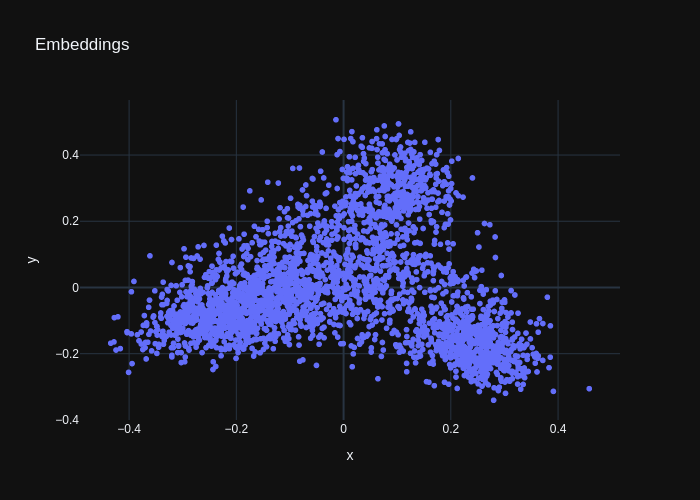

In [9]:
# scatter plot
hover_data = {
    "text_short": True,
    "x": False,
    "y": False
}
fig = px.scatter(df, x="x", y="y", 
                template="plotly_dark",
                title="Embeddings", hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

## Clustering

In [10]:
# clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=9)
labels = clusterer.fit_predict(reduced_embeddings)
df["label"] = [str(label) for label in labels]
print(f"Num of clusters: {labels.max()}")

Num of clusters: 17


In [11]:
# number of outliers
num_outliers = len(df[df["label"] == "-1"])
print(f"Num of outliers: {num_outliers} ({num_outliers / len(df) * 100:.2f} % of total)")

Num of outliers: 1110 (37.00 % of total)


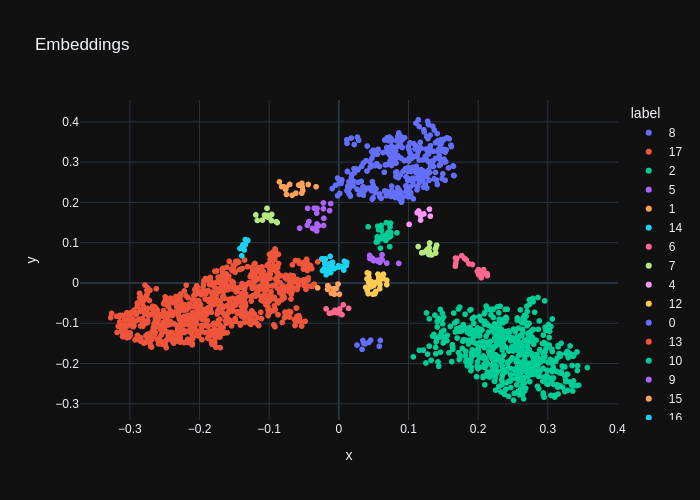

In [12]:
# remove outliers
df_no_outliers = df[df["label"] != "-1"]

# scatter plot
hover_data = {
    "text_short": True,
    "x": False,
    "y": False
}
fig = px.scatter(df_no_outliers, x="x", y="y", template="plotly_dark",
                   title="Embeddings", color="label", hover_data=hover_data)
fig.show()

In [13]:
# show articles in a specific cluster
cluster = "0"
df_subset = df[df["label"] == cluster].reset_index()
for i,row in df_subset.iterrows():
  print(f"- {row['text_short']}")
  if i == 10:
    break

- Shuttle Enterprise Takes Center Stage, at Last (Reuters) Reuters - Space shuttle Enterprise was\born
- Closer, left fielder among most pressing needs Chicago Cubs general manager Jim Hendry got most of h
- Burt Rutan: Building  #39;Tomorrowland #39; One Launch at a Time MOJAVE, California -- Nobody can cl
- Jazz Sign Kirilenko to Contract Extension (AP) AP - Andrei Kirilenko signed a 6-year,  #36;86 millio
- BAR put up for sale. The BAR Formula One team has officially been put up for sale by administrators 
- Mercedes pins hopes on Sports Tourers The world premiere of the Mercedes Sports Tourer models is the
- Back in the game The point man of a private group #39;s attempt to bring the Montreal Expos to Las V
- Trulli and Alonso profit from Renault #39;s compromise Racing at Spa is tricky enough in the dry but
- 18 Holes on 2 Wheels Is the Segway  a futuristic, two-wheeled, self-balancing "human transporter"  h


## Give Meaningful Names to Clusters

In [14]:
# extracting keywords from texts with KeyBERT
cluster = "0"
df_subset = df[df["label"] == cluster].reset_index()
texts_concat = ". ".join(df_subset["text"].values)
keywords_and_scores = KeyBERT().extract_keywords(texts_concat,
                                    keyphrase_ngram_range=(1, 1), top_n=10)
print(keywords_and_scores)

[('shuttle', 0.349), ('kirilenko', 0.3312), ('jazz', 0.3178), ('bar', 0.3024), ('mercedes', 0.2972), ('honda', 0.279), ('tourers', 0.2581), ('tourer', 0.2571), ('franchise', 0.2279), ('renault', 0.2138)]


In [15]:
# keep only the keywords with different stem
# def filter_keywords(keywords, n_keep=3):
def filter_keywords(keywords, n_keep=10):
  new_keywords = []
  for candidate_keyword in keywords:
    is_ok = True
    for compare_keyword in keywords:
      if candidate_keyword == compare_keyword:
        continue
      if compare_keyword in candidate_keyword:
        is_ok = False
        break
    if is_ok:
      new_keywords.append(candidate_keyword)
      if len(new_keywords) >= n_keep:
        break
  return new_keywords

keywords = [t[0] for t in keywords_and_scores]
keywords_filtered = filter_keywords(keywords)
print(keywords_filtered)

['shuttle', 'kirilenko', 'jazz', 'bar', 'mercedes', 'honda', 'tourer', 'franchise', 'renault']


In [17]:
# assign a meaningful name to each cluster

def get_cluster_name(df, cluster):
  df_subset = df[df["label"] == cluster].reset_index()
  texts_concat = ". ".join(df_subset["text"].values)
  kw_model = KeyBERT()
  keywords_and_scores = kw_model.extract_keywords(texts_concat, keyphrase_ngram_range=(1, 1),
                                      top_n=10)
  keywords = [t[0] for t in keywords_and_scores]
  keywords_filtered = filter_keywords(keywords)
  return " - ".join(keywords_filtered)

# get all the new cluster names
all_clusters = df_no_outliers["label"].unique()
d_cluster_name_mapping = {}
for cluster in all_clusters:
  if cluster == "-1":
    d_cluster_name_mapping[cluster] = "outliers"
  else:
    d_cluster_name_mapping[cluster] = get_cluster_name(df_no_outliers, cluster)

# rename clusters
df_no_outliers["label"] = df_no_outliers["label"].apply(lambda label: d_cluster_name_mapping[label])

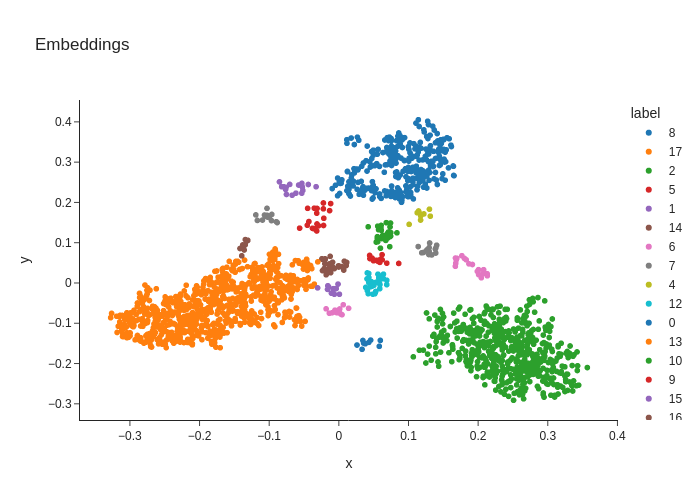

In [16]:
# scatter plot
hover_data = {
    "text_short": True,
    "x": False,
    "y": False
}
fig = px.scatter(df_no_outliers, x="x", y="y", template="simple_white",
                   title="Embeddings", color="label", hover_data=hover_data)
fig.show()

# References

- [2.12 Project: Clustering Newspaper Articles — Practical NLP with Python](https://www.nlplanet.org/course-practical-nlp/02-practical-nlp-first-tasks/12-clustering-articles)

- [My practice on different types of clustering](https://github.com/emrulk1/AI-ML-Data-Science-Practice/tree/main/ML_practice/Unsupervised_Learning/01_Clustering)